<a href="https://colab.research.google.com/github/Hajara-Waseem/LAB-TASK-11_DiP/blob/main/TASK_11_DIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
from google.colab import files

# This will open a file picker dialog to let you select and upload files.
uploaded = files.upload()

for filename in uploaded.keys():
  print(f'User uploaded file "{filename}" with length {len(uploaded[filename])} bytes')

Saving bowsprit_daisy_1_559463.jpg to bowsprit_daisy_1_559463.jpg
User uploaded file "bowsprit_daisy_1_559463.jpg" with length 28156 bytes


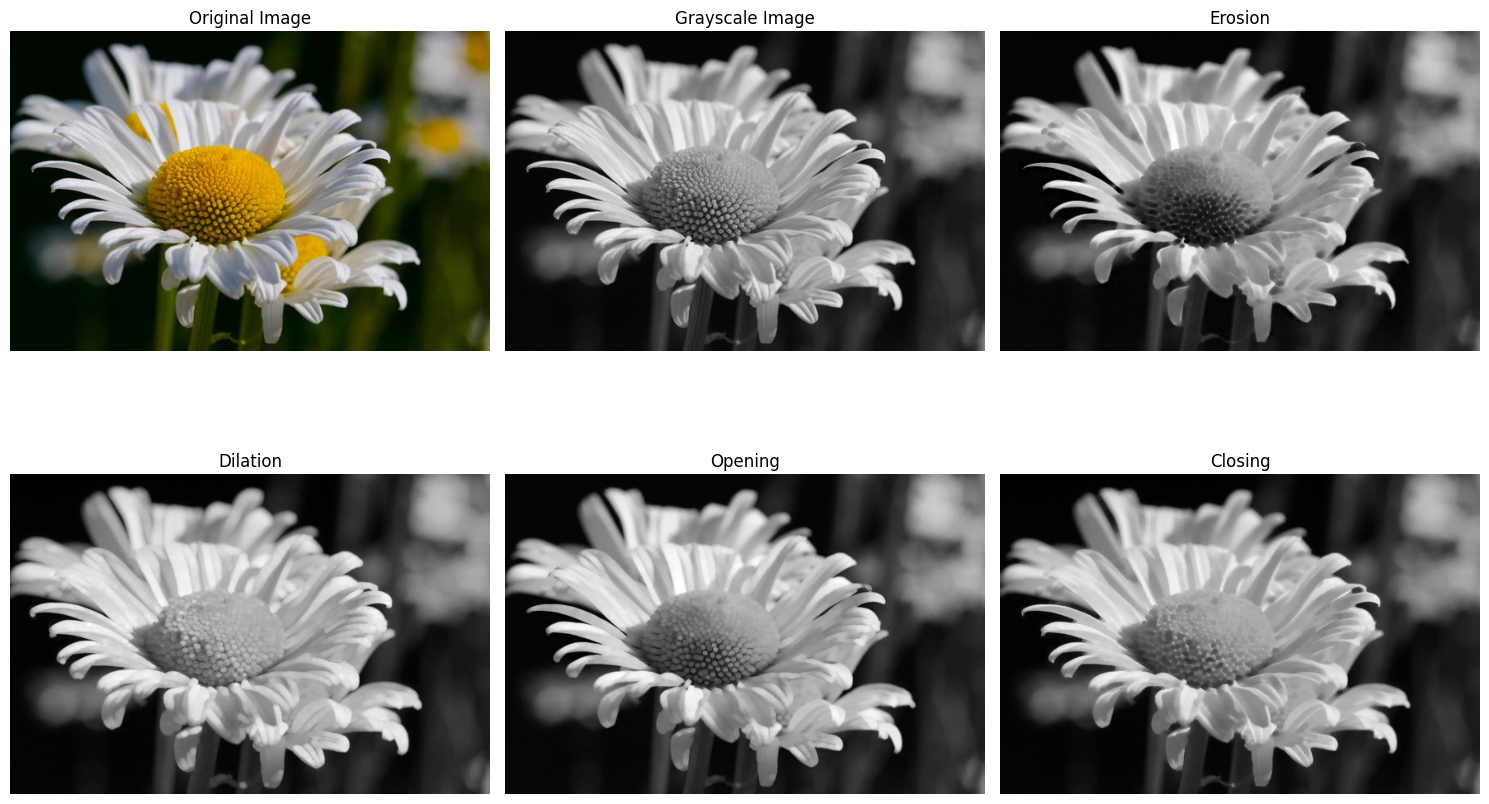

In [ ]:
image_data = uploaded[filename]
image_array = np.frombuffer(image_data, np.uint8)
img = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

# Convert the image to grayscale
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Define a kernel for morphological operations (e.g., a 5x5 ellipse kernel)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

# Perform Erosion
erosion = cv2.erode(gray_img, kernel, iterations=1)

# Perform Dilation
dilation = cv2.dilate(gray_img, kernel, iterations=1)

# Perform Opening (Erosion followed by Dilation)
opening = cv2.morphologyEx(gray_img, cv2.MORPH_OPEN, kernel)

# Perform Closing (Dilation followed by Erosion)
closing = cv2.morphologyEx(gray_img, cv2.MORPH_CLOSE, kernel)

# Display the results
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(gray_img, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(erosion, cmap='gray')
plt.title('Erosion')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(dilation, cmap='gray')
plt.title('Dilation')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(opening, cmap='gray')
plt.title('Opening')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(closing, cmap='gray')
plt.title('Closing')
plt.axis('off')

plt.tight_layout()
plt.show()

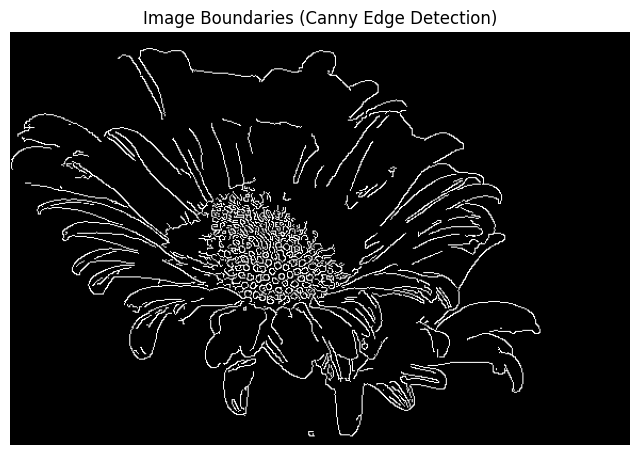

In [ ]:
# Apply Canny edge detector to extract boundaries
edges = cv2.Canny(gray_img, 100, 200) # You might need to adjust the threshold values

# Display the boundaries
plt.figure(figsize=(8, 6))
plt.imshow(edges, cmap='gray')
plt.title('Image Boundaries (Canny Edge Detection)')
plt.axis('off')
plt.show()

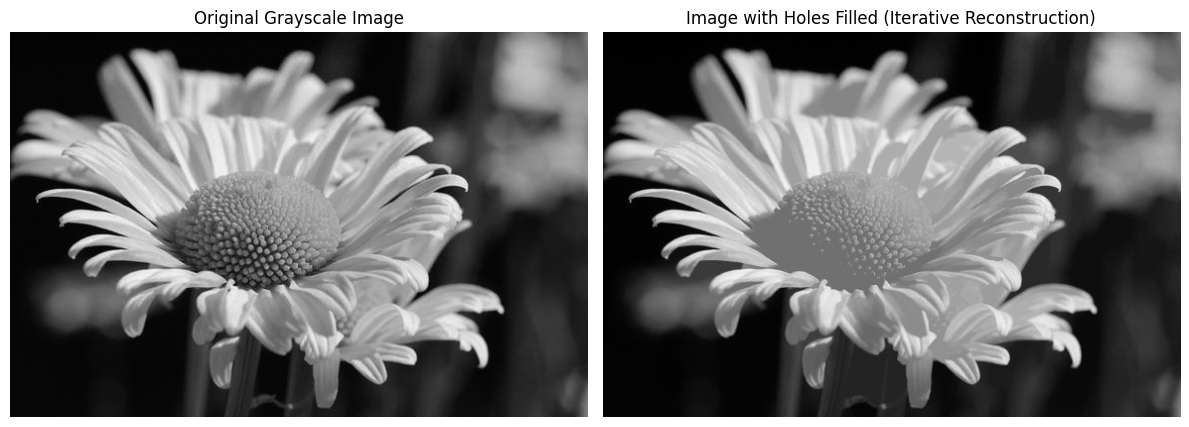

In [ ]:
# Assume gray_img is available. We want to fill dark holes.

# 1. Invert the grayscale image: holes become bright (255), objects/background become dark (0).
#    This inverted image will serve as the 'mask' for reconstruction.
inverted_mask = cv2.bitwise_not(gray_img)

# 2. Create the 'marker' image.
#    Start with a copy of the inverted mask.
#    Set all interior pixels of the marker to 0. This means only the border of the inverted mask remains non-zero.
marker_for_reconstruction = inverted_mask.copy()
marker_for_reconstruction[1:-1, 1:-1] = 0 # Set interior to black

# 3. Define a structuring element (kernel) for dilation.
kernel_recon = np.ones((3,3), np.uint8)

# 4. Perform iterative geodesic dilation (reconstruction by dilation).
#    Repeatedly dilate the marker, but "clip" it by the inverted_mask.
#    The process stops when the marker image no longer changes (convergence).
prev_marker = np.copy(marker_for_reconstruction)
while True:
    marker_for_reconstruction = cv2.dilate(marker_for_reconstruction, kernel_recon)
    marker_for_reconstruction = cv2.min(marker_for_reconstruction, inverted_mask) # Clip by the mask
    if np.array_equal(marker_for_reconstruction, prev_marker):
        break
    prev_marker = np.copy(marker_for_reconstruction)

# 5. The `marker_for_reconstruction` now contains the inverted image with holes filled.
#    These are the areas that were successfully reconstructed from the border, effectively filling the bright holes in the inverted image.

# 6. Invert the result back to get the original image with dark holes filled.
#    The areas that were originally dark holes (now filled bright in marker_for_reconstruction) will become dark again.
#    The areas that were originally bright objects (now dark in marker_for_reconstruction) will become bright again.
#    This will effectively fill the dark holes in the context of the original grayscale image.
image_with_holes_filled = cv2.bitwise_not(marker_for_reconstruction)

# Display the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(gray_img, cmap='gray')
plt.title('Original Grayscale Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_with_holes_filled, cmap='gray')
plt.title('Image with Holes Filled (Iterative Reconstruction)')
plt.axis('off')

plt.tight_layout()
plt.show()

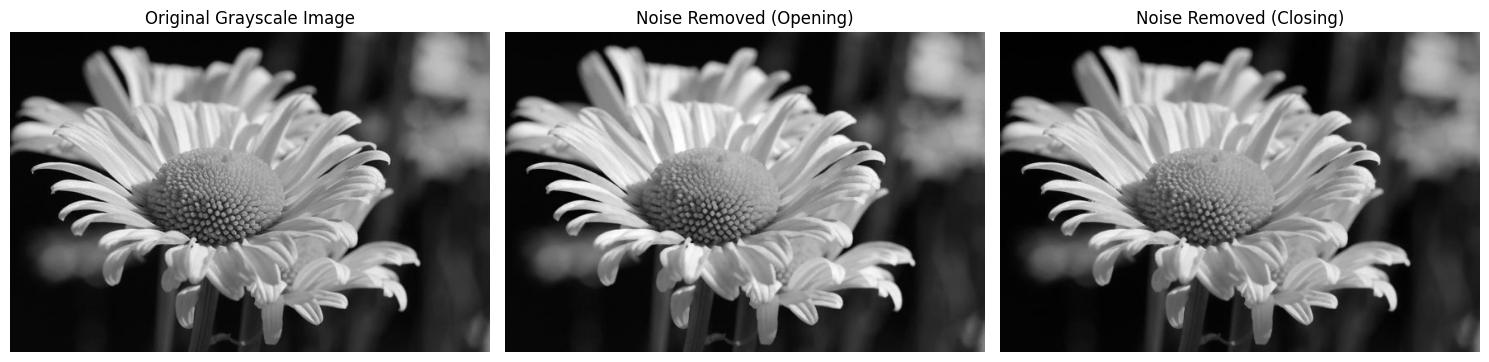

In [ ]:
# Define a kernel (e.g., a 3x3 or 5x5 ellipse kernel) for morphological operations
# A smaller kernel (e.g., 3x3) will remove smaller noise, a larger one will remove more significant noise.
kernel_noise_removal = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

# Perform Opening to remove small bright spots (salt noise) and thin connections
# Opening = Erosion followed by Dilation
opening_for_noise = cv2.morphologyEx(gray_img, cv2.MORPH_OPEN, kernel_noise_removal)

# Perform Closing to remove small dark spots (pepper noise) and fill small holes
# Closing = Dilation followed by Erosion
closing_for_noise = cv2.morphologyEx(gray_img, cv2.MORPH_CLOSE, kernel_noise_removal)

# Display the results
plt.figure(figsize=(15, 7))

plt.subplot(1, 3, 1)
plt.imshow(gray_img, cmap='gray')
plt.title('Original Grayscale Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(opening_for_noise, cmap='gray')
plt.title('Noise Removed (Opening)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(closing_for_noise, cmap='gray')
plt.title('Noise Removed (Closing)')
plt.axis('off')

plt.tight_layout()
plt.show()

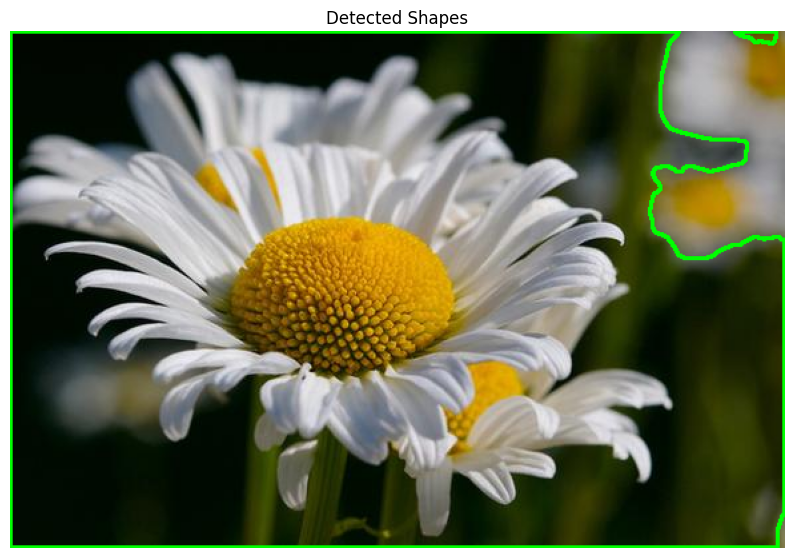

In [ ]:
# Make a copy of the original color image to draw on
img_shapes = img.copy()

# Convert to grayscale (if not already done) and then to binary
# Using adaptive thresholding for better results with varying lighting
gray_for_shapes = cv2.cvtColor(img_shapes, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray_for_shapes, (5, 5), 0)
_, binary_for_shapes = cv2.threshold(blurred, 100, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Find contours in the binary image
contours, _ = cv2.findContours(binary_for_shapes, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Iterate through the contours and detect shapes
for contour in contours:
    # Approximate the contour
    epsilon = 0.04 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)

    # Get bounding box and aspect ratio
    x, y, w, h = cv2.boundingRect(approx)
    aspect_ratio = float(w) / h

    # Determine the shape based on the number of vertices
    shape_name = "unidentified"

    if len(approx) == 3:
        shape_name = "Triangle"
    elif len(approx) == 4:
        # Check if it's a square or rectangle
        if aspect_ratio >= 0.95 and aspect_ratio <= 1.05:
            shape_name = "Square"
        else:
            shape_name = "Rectangle"
    elif len(approx) > 4 and len(approx) < 9:
        # Could be a pentagon, hexagon, octagon etc.
        shape_name = f"{len(approx)}-sided polygon"
    else:
        # If it has many vertices, it's likely a circle or irregular shape
        # Check circularity (area / perimeter^2)
        area = cv2.contourArea(contour)
        (x_circ, y_circ), radius = cv2.minEnclosingCircle(contour)
        circle_area = np.pi * (radius ** 2)
        if area > 0 and (area / circle_area) > 0.8: # Threshold for circularity
            shape_name = "Circle"
        else:
            shape_name = "Other"

    # Draw the contour and label the shape
    cv2.drawContours(img_shapes, [contour], -1, (0, 255, 0), 2) # Green contour
    cv2.putText(img_shapes, shape_name, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2) # Red text

# Display the result
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(img_shapes, cv2.COLOR_BGR2RGB))
plt.title('Detected Shapes')
plt.axis('off')
plt.show()